# Análisis exploratorio de datos

Este notebook muestra como visualizar los datos 

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import locale

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

sns.set_context('talk')
#locale.setlocale(locale.LC_TIME, "es")

In [97]:
dataFile = '../results/afp_chile_2020.csv'

dataDF = pd.read_csv(dataFile, parse_dates=['fecha'])
#dataDF.set_index('fecha', inplace=True)
dataDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio
0,2020-01-01,A,CAPITAL,48914.38,4.075437e+12
1,2020-01-01,A,CUPRUM,51398.91,5.095773e+12
2,2020-01-01,A,HABITAT,52141.66,5.928281e+12
3,2020-01-01,A,MODELO,50732.63,1.202176e+12
4,2020-01-01,A,PLANVITAL,47650.90,4.987370e+11


Agregamos columna con el dia de la semana (Lunes = 0)

In [98]:
dataDF['dia semana'] = dataDF['fecha'].dt.dayofweek

In [99]:
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4165 entries, 0 to 4164
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha             4165 non-null   datetime64[ns]
 1   fondo             4165 non-null   object        
 2   administradora    4165 non-null   object        
 3   valor cuota       4165 non-null   float64       
 4   valor patrimonio  4165 non-null   float64       
 5   dia semana        4165 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 195.4+ KB


In [100]:
afpDF = dataDF.copy()
afpDF = afpDF[afpDF['dia semana'] < 5]

afpDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio,dia semana
0,2020-01-01,A,CAPITAL,48914.38,4.075437e+12,2
1,2020-01-01,A,CUPRUM,51398.91,5.095773e+12,2
2,2020-01-01,A,HABITAT,52141.66,5.928281e+12,2
3,2020-01-01,A,MODELO,50732.63,1.202176e+12,2
4,2020-01-01,A,PLANVITAL,47650.90,4.987370e+11,2


# AFP Habitat

## Análisis de valor cuota

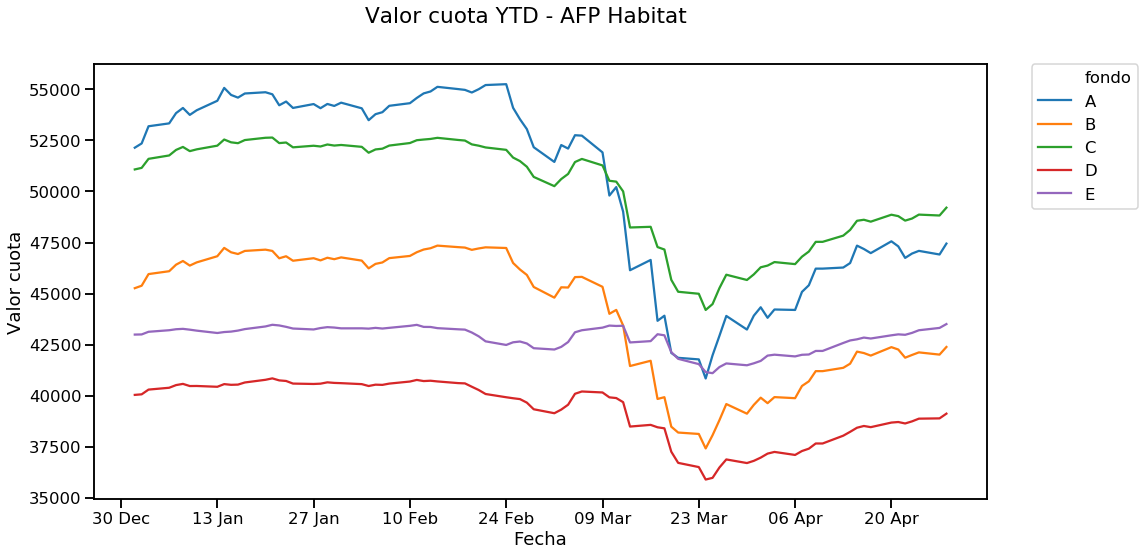

In [102]:
plotDF = afpDF[(afpDF['administradora'] == 'HABITAT')]

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='valor cuota', hue='fondo',
             data=plotDF, ax=ax)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle('Valor cuota YTD - AFP Habitat', fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Valor cuota', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

Calculamos un promedio movil usando ventana de 5 y 8 dias

In [110]:
for name, group in afpDF.groupby(['fondo','administradora']):
    afpDF.loc[group.index, 'valor cuota SMA5'] = group['valor cuota'].rolling(window=5).mean()
    afpDF.loc[group.index, 'valor cuota SMA8'] = group['valor cuota'].rolling(window=8).mean()
    
afpDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio,dia semana,valor cuota SMA5,valor cuota SMA8,rentabilidad YTD,rentabilidad diaria,rentabilidad SMA8
0,2020-01-01,A,CAPITAL,48914.38,4.075437e+12,2,NaN,NaN,0.0,NaN,NaN
1,2020-01-01,A,CUPRUM,51398.91,5.095773e+12,2,NaN,NaN,0.0,NaN,NaN
2,2020-01-01,A,HABITAT,52141.66,5.928281e+12,2,NaN,NaN,0.0,NaN,NaN
3,2020-01-01,A,MODELO,50732.63,1.202176e+12,2,NaN,NaN,0.0,NaN,NaN
4,2020-01-01,A,PLANVITAL,47650.90,4.987370e+11,2,NaN,NaN,0.0,NaN,NaN


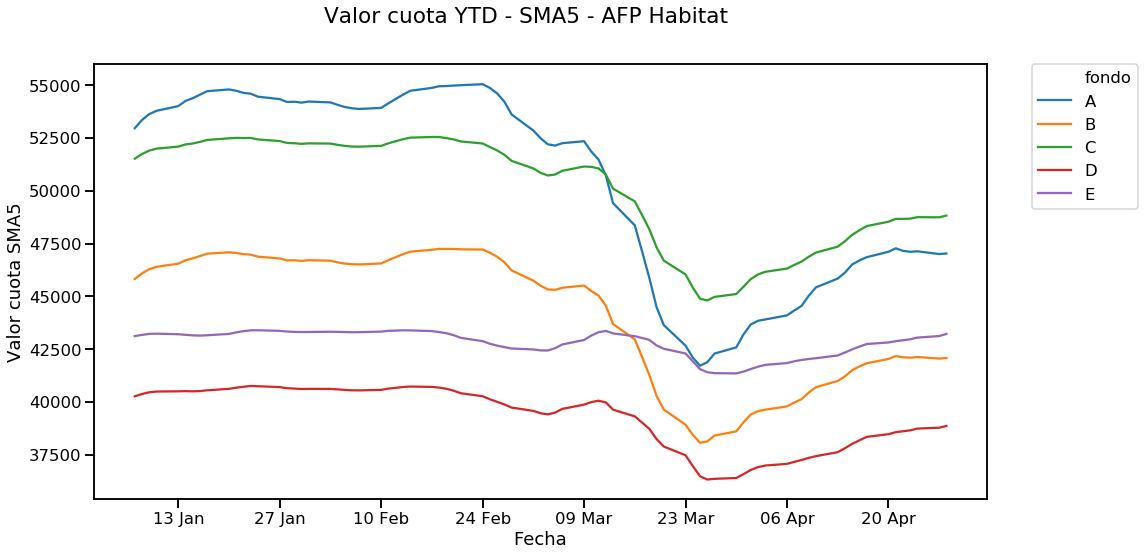

In [111]:
plotDF = afpDF[afpDF['administradora'] == 'HABITAT']

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='valor cuota SMA5', hue='fondo',
             data=plotDF, ax=ax)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle('Valor cuota YTD - SMA5 - AFP Habitat', fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Valor cuota SMA5', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

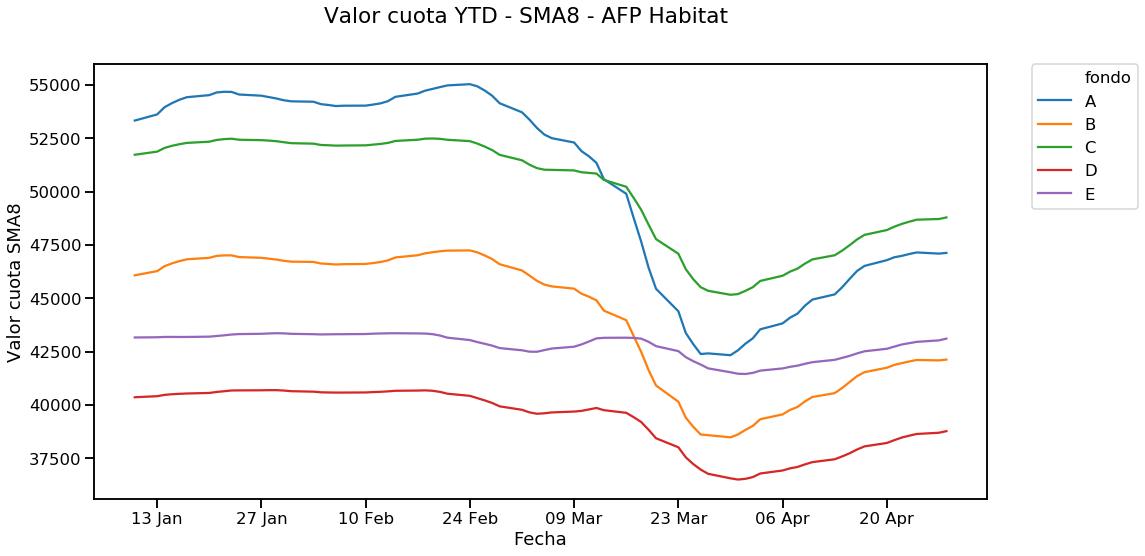

In [112]:
plotDF = afpDF[afpDF['administradora'] == 'HABITAT']

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='valor cuota SMA8', hue='fondo',
             data=plotDF, ax=ax)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle('Valor cuota YTD - SMA8 - AFP Habitat', fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Valor cuota SMA8', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

## Análisis de rentabilidad

Calculamos y graficamos la variaciones porcentuales desde comienzo del año

In [116]:
for name, group in afpDF.groupby(['fondo','administradora']):
    
    # rentabilidad YTD
    refValue = group.iloc[0]['valor cuota']
    afpDF.loc[group.index, 'rentabilidad YTD'] = ((group['valor cuota'] - refValue)/refValue * 100)

    # rentabilidad diaria
    afpDF.loc[group.index, 'rentabilidad diaria'] = (group['valor cuota'] / group['valor cuota'].shift(1)) -1
    
    # rentabilidad media 8
    afpDF.loc[group.index, 'rentabilidad SMA8'] = (group['valor cuota SMA8'] / group['valor cuota SMA8'].shift(1)) -1
    
afpDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio,dia semana,valor cuota SMA5,valor cuota SMA8,rentabilidad YTD,rentabilidad diaria,rentabilidad SMA8
0,2020-01-01,A,CAPITAL,48914.38,4.075437e+12,2,NaN,NaN,0.0,NaN,NaN
1,2020-01-01,A,CUPRUM,51398.91,5.095773e+12,2,NaN,NaN,0.0,NaN,NaN
2,2020-01-01,A,HABITAT,52141.66,5.928281e+12,2,NaN,NaN,0.0,NaN,NaN
3,2020-01-01,A,MODELO,50732.63,1.202176e+12,2,NaN,NaN,0.0,NaN,NaN
4,2020-01-01,A,PLANVITAL,47650.90,4.987370e+11,2,NaN,NaN,0.0,NaN,NaN


Rentabilidad YTD

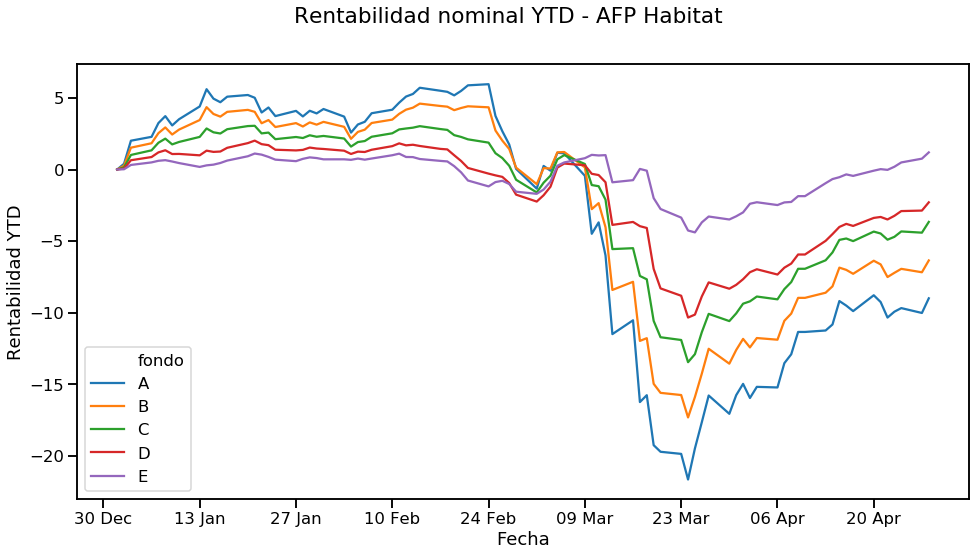

In [117]:
plotDF = afpDF[afpDF['administradora'] == 'HABITAT']

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='rentabilidad YTD', hue='fondo',
             data=plotDF, ax=ax)

fig.suptitle('Rentabilidad nominal YTD - AFP Habitat', fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Rentabilidad YTD', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

Rentabilidad SMA8

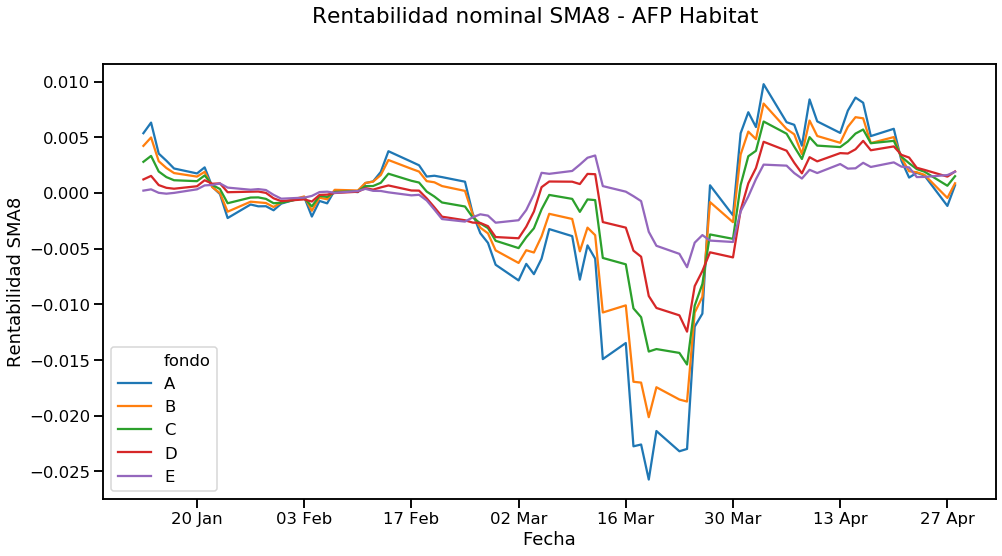

In [118]:
plotDF = afpDF[afpDF['administradora'] == 'HABITAT']

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='rentabilidad SMA8', hue='fondo',
             data=plotDF, ax=ax)

fig.suptitle('Rentabilidad nominal SMA8 - AFP Habitat', fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Rentabilidad SMA8', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

## Graficamos los valores de cuota para la AFP Capital

In [120]:
administradoraName = 'CAPITAL'

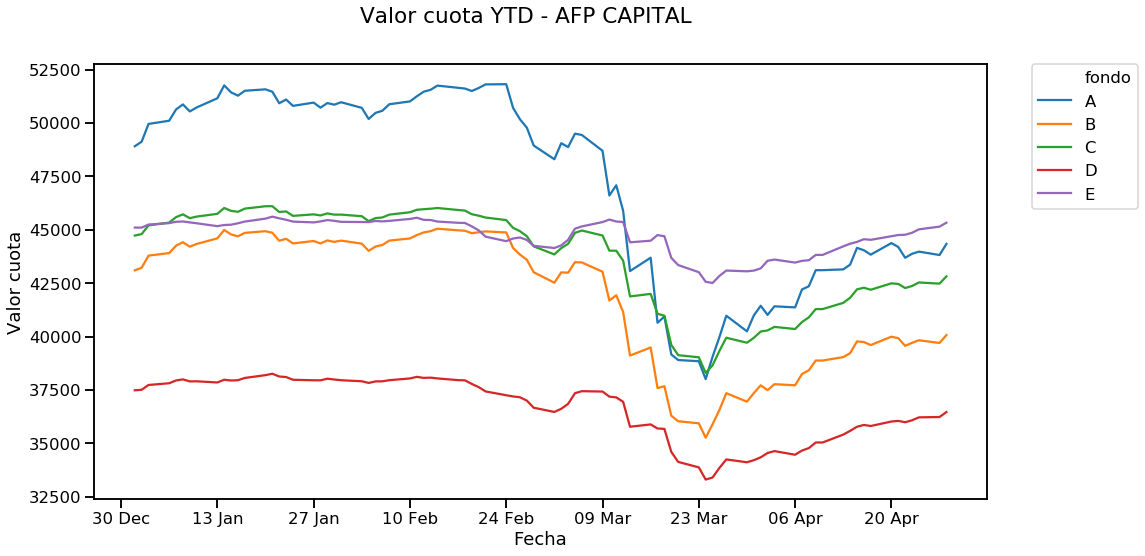

In [121]:
plotDF = afpDF[(afpDF['administradora'] == administradoraName)]

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='valor cuota', hue='fondo',
             data=plotDF, ax=ax)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle('Valor cuota YTD - AFP '+administradoraName, fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Valor cuota', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

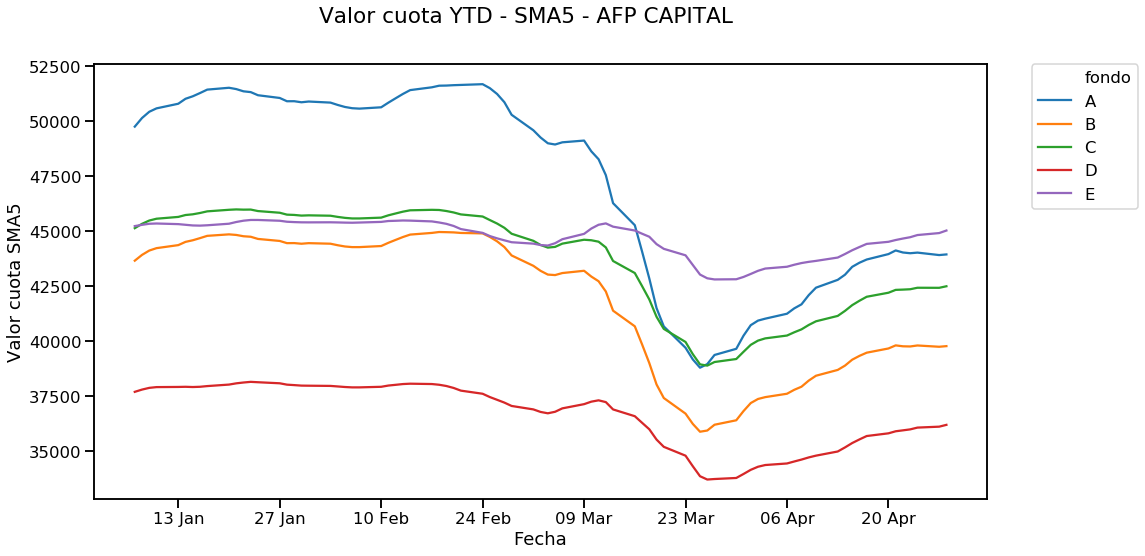

In [122]:
plotDF = afpDF[afpDF['administradora'] == administradoraName]

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='valor cuota SMA5', hue='fondo',
             data=plotDF, ax=ax)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle('Valor cuota YTD - SMA5 - AFP '+administradoraName, fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Valor cuota SMA5', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

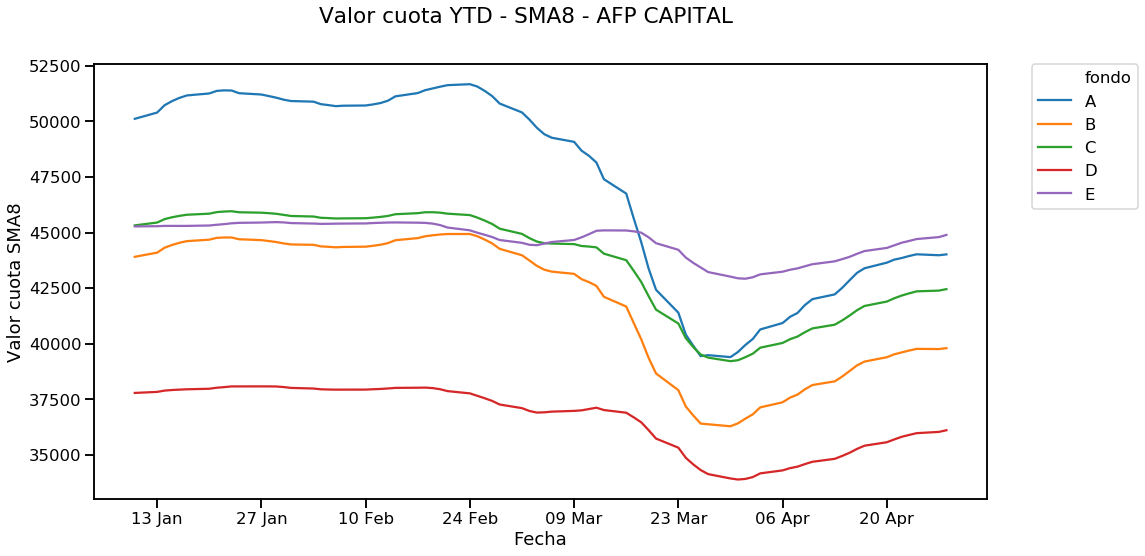

In [123]:
plotDF = afpDF[afpDF['administradora'] == administradoraName]

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='valor cuota SMA8', hue='fondo',
             data=plotDF, ax=ax)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle('Valor cuota YTD - SMA8 - AFP '+administradoraName, fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Valor cuota SMA8', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

## Análisis de rentabilidad

Calculamos y graficamos la variaciones porcentuales desde comienzo del año

Rentabilidad YTD

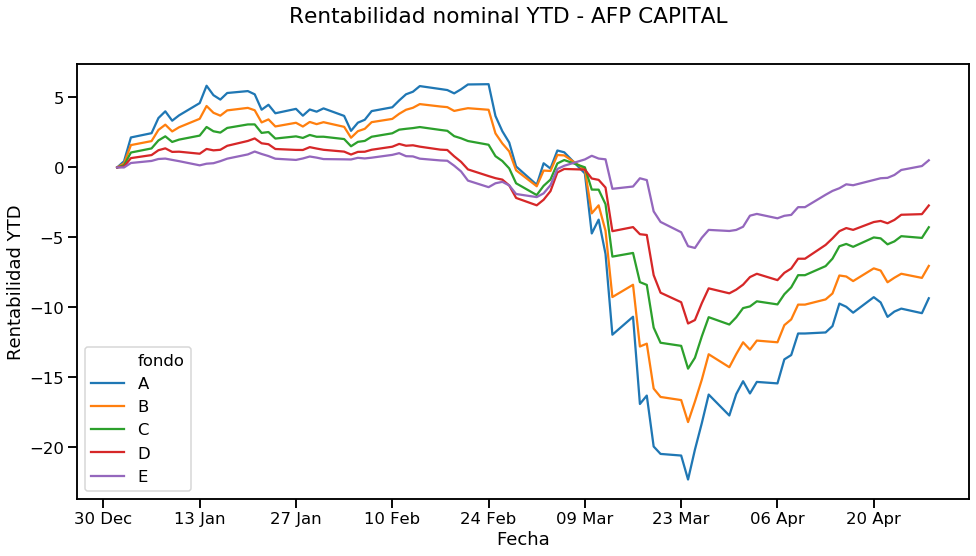

In [124]:
plotDF = afpDF[afpDF['administradora'] == administradoraName]

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='rentabilidad YTD', hue='fondo',
             data=plotDF, ax=ax)

fig.suptitle('Rentabilidad nominal YTD - AFP '+administradoraName, fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Rentabilidad YTD', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

Rentabilidad SMA8

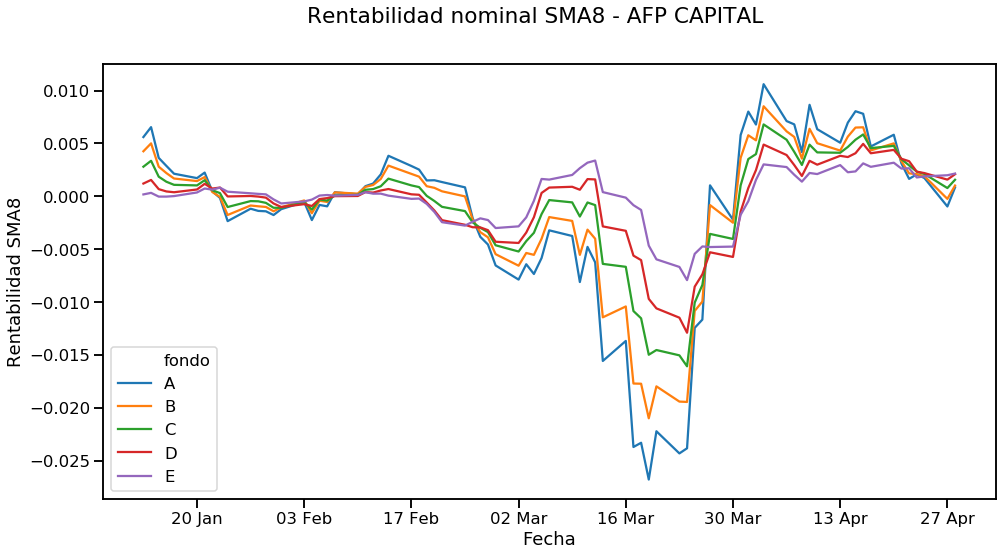

In [125]:
plotDF = afpDF[afpDF['administradora'] == administradoraName]

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='rentabilidad SMA8', hue='fondo',
             data=plotDF, ax=ax)

fig.suptitle('Rentabilidad nominal SMA8 - AFP '+administradoraName, fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Rentabilidad SMA8', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))